some prereading: 

[Approaching (Almost) Any Machine Learning Problem](http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/)


# Step 1 - get data

In [171]:
import datetime as dt
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
# https://stackoverflow.com/a/50970152
pd.core.common.is_list_like = pd.api.types.is_list_like
# you have to install pandas_datareader module i Anaconda Navigator:
# http://docs.anaconda.com/anaconda/navigator/tutorials/manage-packages/
from pandas_datareader.data import DataReader

In [172]:
# Define timeframe of stocks we retreive 
end = dt.datetime.now() 
start = end - dt.timedelta(days=5*365)

In [173]:
df = DataReader('MU','iex', start, end)
df.head()

5y


,open,high,low,close,volume
date,,,,,
2013-10-01,17.54,17.750,17.34,17.610,32962745
2013-10-02,17.65,18.130,17.55,17.665,48967853
2013-10-03,17.94,18.100,17.37,18.015,58897371
2013-10-04,18.08,18.545,18.01,18.470,48056969
2013-10-07,18.77,18.850,18.48,18.485,61944447


In [174]:
df.tail()

,open,high,low,close,volume
date,,,,,
2018-09-24,44.20,45.6500,43.860,45.16,36918937
2018-09-25,45.10,45.4606,44.020,44.64,32547450
2018-09-26,44.29,44.7600,43.960,44.35,30299841
2018-09-27,44.23,45.5200,44.046,44.99,26952377
2018-09-28,44.65,45.6100,44.490,45.23,28080411


In [175]:
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

# Step 2 - Use close price as input

In [176]:
df = df[['close']]

# Step 3 - Create a label 1-day ahead, split input and label to different arrays, scale values

In [177]:
forecast_out = int(1) 
df['prediction'] = df.shift(-forecast_out) #  label column with data shifted 1 unit up
print(df.tail())

            close  prediction
date                         
2018-09-24  45.16       44.64
2018-09-25  44.64       44.35
2018-09-26  44.35       44.99
2018-09-27  44.99       45.23
2018-09-28  45.23         NaN


In [178]:
from sklearn import preprocessing

X = np.array(df.drop(['prediction'], 1)) #drop labels
X = X[:-forecast_out] # remove last 1 from X as its prediction is NaN
y = np.array(df['prediction']) # assign labels to variable y
y = y[:-forecast_out] # remove the last NaN

#scale values
y = y.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(y)
X = scaler.transform(X)
y = scaler.transform(y)

print(X)
print(y)

[[-0.83318455]
 [-0.82883337]
 [-0.80114404]
 ...
 [ 1.30522275]
 [ 1.28228016]
 [ 1.33291208]]
[[-0.82883337]
 [-0.80114404]
 [-0.76514791]
 ...
 [ 1.28228016]
 [ 1.33291208]
 [ 1.35189905]]


# Step 3 - Train the linear model

In [179]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, ElasticNetCV, Ridge
from sklearn.neural_network import MLPRegressor

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
linear = ElasticNetCV() #we choose ElasticNetCV model

linear.fit(X_train, y_train.reshape(len(y_train),))


ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

# Step 4 - Calculate confidence and prediction

In [180]:
confidence = linear.score(X_test, y_test)
print("confidence: ", confidence)

confidence:  0.9390089036236626


In [181]:
forecast_set = linear.predict(X_test)

# Step 5 -  Visualize prediction and close price in same chart

<IPython.core.display.Javascript object>


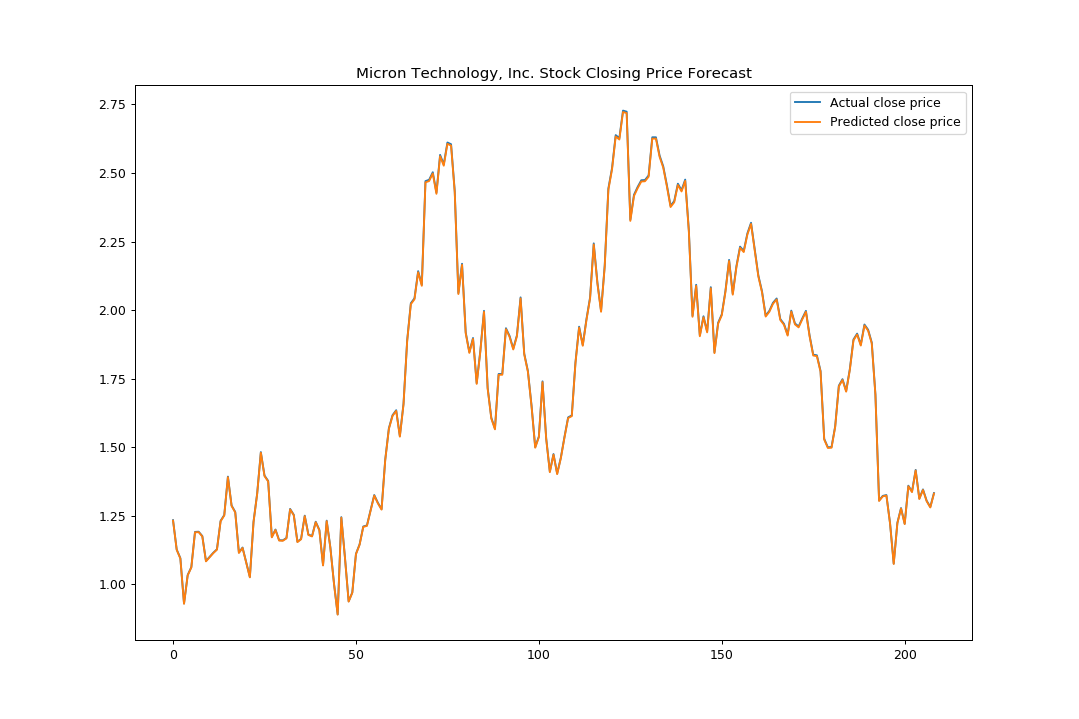

In [184]:
d = {'Actual close price': np.ndarray.flatten(X_test), 'Predicted close price': forecast_set}
result_df = pd.DataFrame(d)
result_df.plot(figsize=(12,8), title='Micron Technology, Inc. Stock Closing Price Forecast')